# A leggyakoribb érték módszere

A leggyakoribb érték (Most Frequent Value, MFV) módszerét és annak elméleti hátterét a Steiner Ferenc által vezetett kutatócsoport dolgozta ki közel fél évszázada. Az eljárást széles körben alkalmazzák különböző földtudományi problémák megoldására. Az MFV módszernek jelentős előnyei vannak a "maximum likelihood" elven alapuló klasszikus statisztikai módszerekkel szemben. Idézve Steiner Ferenc: A geostatisztika alapjai (1990) [könyvének](http://antikva.hu/geologia/a-geostatisztika-alapjai) bevezetőjét, a "robusztus statisztika olyan elméleti keret, amelyen belül gazdaságosan oldható meg aza feladat, hogy egymástól jelentősen különböző eloszlástípusok esetén is megbízható eredményt érjünk el, valamint hogy ne legyünk kitéve a durva hibák torzító (esetleg katasztrofális mértékben torzító) hatásának." Az első követelményt, vagyis hogy egymástól jelentősen különböző eloszlástípusok esetén is megbízható eredményt érjünk el nevezi Steiner **robusztusság**nak. A másodikat, vagyis hogy ne legyünk kitéve a durva hibák torzító hatásának, nevezi **rezisztenciá**nak.

A következőkben ismertetjük az MFV módszer alapgondolatát és mintapéldákon keresztül mutatjuk be az alkalmazását.

## Adatrendszerek, hisztogramok és sűrűségmodellek

Steiner (1990) tankönyvében példaként a Borsod II. széntelepnek a Sajószentpéter-Múcsony területre vonatkozó, barnakőszén-telep vastagság adatait elemzi. Magukat az adatokat a könyv nem közli, de az 1.2 ábrán láthatjuk az adatok hisztogramját, amelyből előállíthatjuk az adatsorozatot is ([telep.dat](telep.dat)).

Először is olvassuk be ezeket az adatokat és rajzoltassuk ki a tapasztalati sűrűség hisztogramot.

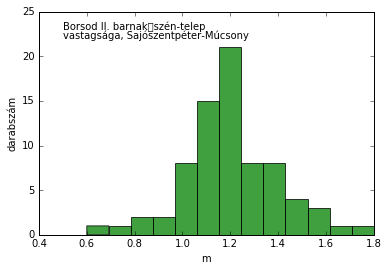

In [1]:
from __future__ import unicode_literals
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Borsod II. barnaszéntelep vastagsága Sajószentpéter-Múcsony
# Steiner F.: A geostatisztika alapjai, 1990, 17.oldal
# telep vastagság adatok m-ben
dat = np.loadtxt('telep.dat')

# hisztogram rajzolása
n, bins, patches = plt.hist(dat, 13, normed=False, facecolor='green', alpha=0.75)

plt.xlabel('m')
plt.ylabel(u'darabszám')
plt.text(0.5,23, u'Borsod II. barnakőszén-telep')
plt.text(0.5,22, u'vastagsága, Sajószentpéter-Múcsony')
plt.show()

Vajon milyen eloszlást követnek ezek az adatok? Bár csak 75 telepvastagság adatunk van, ami kicsit kevés az eloszlástípus egyértelmű meghatározásához, de megpróbálhatunk néhány ismert eloszlástípust illeszteni az adatokhoz.

Ehhez a `scipy.stats` modulját használjuk, illetve az abban található [Kolmogorov-Szmirnov](https://hu.wikipedia.org/wiki/Kolmogorov%E2%80%93Szmirnov-pr%C3%B3ba) próbát.

cauchy          p: 0.0410338976279          D: 0.15853756077
laplace         p: 0.0273511670756          D: 0.166666597445
norm            p: 0.0185094295307          D: 0.174129509241
uniform         p: 0.000160397281854        D: 0.247154803426
-------------------------------------------------------------------
Legjobb 4
-------------------------------------------------------------------
1    cauchy           	p:  0.0410338976279 	D:  0.15853756077
2    laplace          	p:  0.0273511670756 	D:  0.166666597445
3    norm             	p:  0.0185094295307 	D:  0.174129509241
4    uniform          	p:  0.000160397281854 	D:  0.247154803426


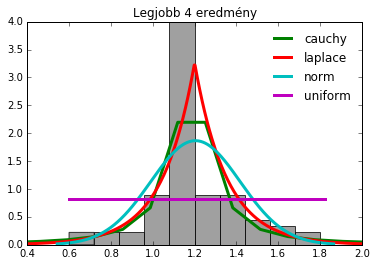

In [7]:
from __future__ import print_function
import scipy.stats
import math

cdfs = {
    "cauchy": {"p":[], "D": []},          #Cauchy
    "laplace": {"p":[], "D": []},         #Laplace
    "norm": {"p":[], "D": []},            #Normal (Gaussian)
    "uniform": {"p":[], "D": []}}         #Uniform

def check(data, fct, verbose=False):
    #illesztjük adatainkat az összes eloszlás típushoz
    parameters = eval("scipy.stats."+fct+".fit(data)");
    #a Kolmogorov-Szmirnov kétoldali próbát alkalmazzuk
    D, p = scipy.stats.kstest(data, fct, args=parameters);

    if math.isnan(p): p=0
    if math.isnan(D): D=0

    if verbose:
        print(fct.ljust(16) + "p: " + str(p).ljust(25) + "D: " +str(D))

    return (fct, p, D)

def plot(fcts, data):
    import matplotlib.pyplot as plt
    import numpy as np

    # adatok hisztogramjának a kirajzoltatása
    plt.hist(data, normed=True, bins=max(10, len(data)/10), facecolor='grey', alpha=0.75)

    # kirajzoljuk az illesztett eloszlásokat
    for fct in fcts:
        params = eval("scipy.stats."+fct+".fit(data)")
        f = eval("scipy.stats."+fct+".freeze"+str(params))
        x = np.linspace(f.ppf(0.001), f.ppf(0.999), 500)
        plt.plot(x, f.pdf(x), lw=3, label=fct)
    plt.legend(loc='best', frameon=False)
    plt.title("Legjobb "+str(len(fcts))+" eredmény")
    plt.xlim([0.4,2.0])
    plt.show()

data = dat
results = [check(data, fct, True) for fct in cdfs.keys()]
for res in results:
    key, p, D = res
    cdfs[key]["p"].append(p)
    cdfs[key]["D"].append(D)

print( "-------------------------------------------------------------------" )
print( "Legjobb %d" % (4, ) )
print( "-------------------------------------------------------------------" )
best = sorted(cdfs.items(), key=lambda elem : scipy.median(elem[1]["p"]), reverse=True)

for t in range(4):
    fct, values = best[t]
    print( str(t+1).ljust(4), fct.ljust(16),
            "\tp: ", scipy.median(values["p"]),
            "\tD: ", scipy.median(values["D"]),
            end="")
    if len(values["p"]) > 1:
        print("\tvar(p): ", scipy.var(values["p"]),
                "\tvar(D): ", scipy.var(values["D"]), end="")
    print()

plot([b[0] for b in best[:4]], dat)

Az eredményből látható, hogy *nem* a normális, hanem a Cauchy-féle eloszlás illeszkedik legjobban az adatokra. Vajon ez kivéltelesnek mondható? Nézzünk megy egy másik adatrendszert. Az adataink legyenek az MGH-50 gravimetriai hálózatban mért nehézségi gyorsulásokból számított maradék Faye-féle nehézségi rendellenességek, amelyeket az EGM2008 geopotenciális modellel 2160 fokig és rendig redukáltunk. Próbáljunk még több féle eloszlás típussal dolgozni.

uniform         p: 0.0                      D: 0.469410209552
cauchy          p: 0.00368044724799         D: 0.0782908739744
gamma           p: 0.0                      D: 0.192088563627
laplace         p: 0.0268139333298          D: 0.0647396031392
norm            p: 7.07986624882e-09        D: 0.137666769296
t               p: 0.0372637501258          D: 0.0622096062767
-------------------------------------------------------------------
Legjobb 6
-------------------------------------------------------------------
1    t                	p:  0.0372637501258 	D:  0.0622096062767
2    laplace          	p:  0.0268139333298 	D:  0.0647396031392
3    cauchy           	p:  0.00368044724799 	D:  0.0782908739744
4    norm             	p:  7.07986624882e-09 	D:  0.137666769296
5    uniform          	p:  0.0 	D:  0.469410209552
6    gamma            	p:  0.0 	D:  0.192088563627


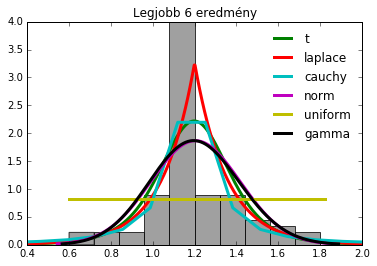

In [8]:
cdfs = {
    "cauchy": {"p":[], "D": []},          #Cauchy
    "gamma": {"p":[], "D": []},           #Gamma
    "laplace": {"p":[], "D": []},         #Laplace
    "norm": {"p":[], "D": []},            #Normal (Gaussian)
    "t": {"p":[], "D": []},               #Student's T
    "uniform": {"p":[], "D": []}}         #Uniform

dg50 = np.loadtxt('dg50.dat')

data = dg50
results = [check(data, fct, True) for fct in cdfs.keys()]
for res in results:
    key, p, D = res
    cdfs[key]["p"].append(p)
    cdfs[key]["D"].append(D)

ncdfs = 6
print( "-------------------------------------------------------------------" )
print( "Legjobb %d" % (ncdfs, ) )
print( "-------------------------------------------------------------------" )
best = sorted(cdfs.items(), key=lambda elem : scipy.median(elem[1]["p"]), reverse=True)

for t in range(ncdfs):
    fct, values = best[t]
    print( str(t+1).ljust(4), fct.ljust(16),
            "\tp: ", scipy.median(values["p"]),
            "\tD: ", scipy.median(values["D"]),
            end="")
    if len(values["p"]) > 1:
        print("\tvar(p): ", scipy.var(values["p"]),
                "\tvar(D): ", scipy.var(values["D"]), end="")
    print()

plot([b[0] for b in best[:ncdfs]], dat)

Láthatjuk, hogy a Student-féle eloszlás illeszkedett legjobban az adatokra. Steiner (1990, 145.o.) megfogalmazása szerint "Newcomb ... a múlt század végén kimondta, hogy nagyon ritka az az eset, amikor az adateloszlás Gauss-típusú (márpedig Newcomb - többek között - csillagász volt, és a csillagászatban közmondásosan pontos méréseket végeznek). Gauss nagy tekintélye sokak szemében és sokáig a Gauss-típus teljesen általános voltának elfogadását eredményezte; ha az adatrendszer szembeszökően más eloszlástípusra utalt, pl. lényegesen hosszabbak voltak a szárnyak, inkább a mérések megbízhatóságát kérdőjelezték meg."

Vajon kell-e foglalkoznunk azzal, hogy a gyakorlatban előforduló adataink eloszlása csak kivételesen Gauss-féle normális eloszlású? A válasz: igen, és ennek oka a statisztikai **hatásfok**.

## Statisztikai hatásfok

Elméletileg egy statisztikai eljárás hatásfokának a definíciója a következő:

*Statisztikai hatásfok = 100 (kinyert információ / összes információ) %*

Szükségünk van egy a gyakorlatban használható definícióra is a hatásfok numerikus számításához. A következő formula megfelelő:

*e = 100 (minimális aszimptotikus szórásnégyzet / aszimptotikus szórásnégyzet) %*

A nevező számítható az aktuális alkalmazott statisztikai eljárásra. A számláló az ún [Cramer-Rao határ](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound). Ha megvizsgáljuk ezt az $f_a(x)$ modellcsaládra, vagyis *szupermodell*re, amely magában foglalja határesetként a Gauss-féle normális, illetve a Cauchy-féle eloszlást:


$$f_a(x) = \frac{ \Gamma \left( \frac{a}{2} \right) }{\sqrt {\pi} \Gamma \left( \frac{a-1}{2} \right) } \frac{1}{(1+x^2)^{a/2}} $$

akkor az alábbi ábrát kapjuk (Steiner, 1997):
![](Steiner1.png)

Jól látszik, hogy bár a legkisebb négyzetek szerinti becslés hatásfoka 100%-os a Gauss-féle anyaeloszlás esetén, szélesebb szárnyakkal rendelkező eloszlások esetén a hatásfoka rohamosan csökken. Márpedig az 50%-os hatásfok azt jelenti, hogy adataink 50%-át eltékozoljuk. Ez sok esetben megengedhetetlen. Viszont az is látszik, hogy az MFV becslések robusztusak, vagyis érzéketlenek az anyaelolszlásra, amit a magas, 90% fölötti hatásfok mutat.

## Leggyakoribb érték

A leggyakoribb érték (MFV) meghatározásának az az alapgondolata, hogy az adatok zömétől távoli pontoknak kicsiny, a legnagyobb adatsűrűségű helyen az adatoknak nagy súlyokat ($\varphi$) adva, a

$$\frac{\sum_{i=1}^{n}\varphi_i x_i}{\sum_{i=1}^{n}\varphi_i}$$

*súlyozott átlag* megbízható, az esetek többségében a számtani átlagnál mindenképpen sokkal megbízhatóbb jellemzőt szolgáltat.

Ennek az alapgondolatnak a megvalósítása szükségképpen vezet iteratív algoritmushoz, hiszen az $M$ "jellemző értéket" már előre tudnunk kellene ahhoz, hogy ott maximális, attól távolodva egyre kisebb súlyokat alkalmazhassunk. 

A súlyfüggvény legyen a következő egyszerű szimmetrikus alakú ($\epsilon$ a súlyfüggvény szélesség paramétere):

$$\varphi_i = \frac{\epsilon^2}{\epsilon^2+(x_i-M)^2}.$$

Az ábrán a súlyfüggvény látható különböző szélességek esetén. ![](Steiner2.png)

Az M **leggyakoribb érték** számításakor tehát a következő egyenletet kielégítő $M_n$-et határozzuk meg (iterációval):

$$M_n=\frac{\sum_{i=1}^{n}\frac{\epsilon^2}{\epsilon^2+(x_i-M_n)^2} x_i}{\sum_{i=1}^{n}\frac{\epsilon^2}{\epsilon^2+(x_i-M_n)^2}}.$$

Az adatok az $M_n$-től való távolsággal a súly szerint egyre csökkenő mértékben járulnak hozzá $M_n$ értékének a kialakításához, ezért kézenfekvő a nevezőben szereplő súlyösszeget effektív pontszámnak [$n_{eff}(\epsilon)$] tekinteni:

$$n_{eff}(\epsilon)=\sum_{i=1}^{n}\frac{\epsilon^2}{\epsilon^2+(x_i-M_n)^2}.$$

Az effektív pontszám elsődleges maximalizálása $\epsilon$-nak ehhez viszonyítva másodlagos, de határozott egyidejű minimalizálásával például akkor valósul meg, ha a következő kifejezést maximalizáljuk:

$$\frac{n_{eff}^2(\epsilon)}{\epsilon}.$$

Ez azzal ekvivalens, hogy az $\epsilon$ skálaparamétert a következő extrémumkövetelménnyel definiáljuk:

$$\sum_{i=1}^{n}\frac{\epsilon^{3/2}}{\epsilon^2+(x_i-M_n)^2} = \mathrm{maximum}.$$

Az összefüggést teljesítő $\epsilon$ a pontok zömének kohéziós tendenciáját jellemzi olyan értelemben, hogy nagy $\epsilon$ kis kohéziót jellemez és megfordítva, így tehát célszerű a kohéziót így definiálni:

$$ \kappa = \frac{1}{\epsilon}.$$

Az $\epsilon$ tehát *reciprok kohéziónak* nevezhető, de az elnevezés nehézkessége miatt inkább a **dihézió** nevet használjuk.





A gyakorlatban $M_n$ és $\epsilon$ szimultán reciprok iterációs eljárással határozható meg. Kimutatható, hogy $\epsilon$ nem lehet nagyobb a mintaterjedelem $\sqrt{3}/2$-szeresénél:

$$\epsilon \le \frac{\sqrt{3}}{2}[\mathrm{max}(x_i) - \mathrm{min}(x_i)].$$

Az $M_n$ kezdőértékeként a minta átlagot vagy mediánt vesszük. Ezután számítjuk $\epsilon$ frissített értékét az alábbi formulával:

$$\epsilon^2_{k+1}=\frac{3\sum_{i=1}^{n}\frac{(x_i-M_n)^2}{[\epsilon_k^2+(x_i-M_n)^2]^2}}{\sum_{i=1}^{n}\frac{1}{[\epsilon_k^2+(x_i-M_n)^2}]^2}.$$

Utána ezzel az új $\epsilon$ értékkel számítjuk ki az $M_n$ újabb értékét a már megadott képlettel, és folytatjuk az $\epsilon$ és $M_n$ szimultán iterációját, amíg már csak jelentéktelen változások következnek be, de a tapasztalatok szerint 10-20 iterációs lépés elegendő pontosságot nyújt.

Írjunk Python függvényt a fenti eljárásra!

In [11]:
def mfd(xk, k=1):
    # eps = dihezio(vk): a vk mérési javításokból számított dihézió
    # xk  : numpy adatrendszer vektor
    # k   : általánosított dihézió paramétere
    # M   : leggyakoribb érték
    # eps : dihézió

    # kiinduló dihézió érték
    e0 = np.sqrt(3.0)/2.0*(np.amax(xk)-np.amin(xk))
    # kiinduló leggyakoribb érték: medián
    M0 = np.median(xk)

    ej = e0
    Mj = M0
    while True:
        vk = xk - Mj
        se = 1.0/(ej**2+vk**2)
        num = vk*se
        den = se
        ej1 = np.sqrt(3.0*np.sum(num**2)/np.sum(den**2))
        se1 = 1.0/((k*ej1)**2+vk**2)
        Mj1 = np.sum(se1*xk)/np.sum(se1)
        if np.fabs(ej1-ej)/ej < 1e-6:
            if np.fabs(Mj1-Mj)/Mj < 1e-6:
                break
        ej = ej1
        Mj = Mj1
    return Mj1,ej1


Számítsuk ki a telepvastagság adatrendszer különböző mintajellemző értékeit.

In [16]:
m,d = mfd(dat)
print ("")
print ("barnakőszéntelep vastagság adatok")
print ("átlag             : %.3f" % np.mean(dat))
print ("medián            : %.3f" % np.median(dat))
print ("leggyakoribb érték: %.3f" % m)
print ("szórás            : %.3f" % np.std(dat))
print ("dihézió           : %.3f" % d)


barnakőszéntelep vastagság adatok
átlag             : 1.204
medián            : 1.200
leggyakoribb érték: 1.185
szórás            : 0.214
dihézió           : 0.115


A medián és a leggyakoribb érték *rezisztens*, azaz érzéketlen a kivágó adatok hatására. Ez nem mondható el sem az átlagról, sem a szórásról. Megjegyezzük, hogy a Cauchy-féle eloszlásnak nem is létezik szórása (végtelen nagy), viszont a szórással analóg dihéziója jól meghatározott szám.

In [18]:
datk = np.append(dat,40.0)
m,d = mfd(datk)
print ("")
print ("barnakőszéntelep vastagság adatok")
print ("átlag             : %.3f" % np.mean(datk))
print ("medián            : %.3f" % np.median(datk))
print ("leggyakoribb érték: %.3f" % m)
print ("szórás            : %.3f" % np.std(datk))
print ("dihézió           : %.3f" % d)


barnakőszéntelep vastagság adatok
átlag             : 1.714
medián            : 1.200
leggyakoribb érték: 1.185
szórás            : 4.426
dihézió           : 0.115


## Általánosított leggyakoribb érték

A leggyakoribb érték fogalma általánosítható az alábbi módon:

$$M_{k;n}=\frac{\sum_{i=1}^{n}\frac{\epsilon^2}{(k\epsilon)^2+(x_i-M_{k;n})^2} x_i}{\sum_{i=1}^{n}\frac{\epsilon^2}{(k\epsilon)^2+(x_i-M_{k;n})^2}}.$$

A korábbi ábrán az $M$ indexe erre utalt.